In [1]:
import pandas as pd
import numpy as np
import librosa
import IPython.display as ipd
from librosa.display import specshow
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv("data/datamatrix.csv", sep=';', index_col=0).transpose().applymap(np.log1p)
data.describe()

,100.110350,102.010985,102.032212,102.535130,109.012080,110.017963,110.522609,111.019337,111.087585,111.521389,...,945.579366,945.605541,946.580795,946.601468,946.617601,947.609497,977.587261,977.606791,978.566742,978.594623
count,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,...,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000
mean,0.020704,0.009390,0.154996,0.014959,0.090451,0.127847,0.013149,0.137530,0.009558,0.009448,...,0.012574,0.069513,0.024659,0.020548,0.021185,0.009739,0.038193,0.007919,0.007633,0.018749
std,0.451992,0.304164,1.230900,0.382977,0.941876,1.116413,0.359912,1.158518,0.309763,0.306057,...,0.372808,0.888858,0.515680,0.471045,0.485450,0.315677,0.652006,0.287219,0.276583,0.452732
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.420405,9.901936,10.961729,10.058823,10.598258,10.952770,9.920984,10.850055,10.580531,10.189606,...,11.969591,12.216003,11.349830,11.589145,11.622255,10.733981,11.924711,11.250651,10.408888,11.471489


In [13]:
am = data.to_numpy()
print(f"{am.shape = }")

am.shape = (5250, 824)


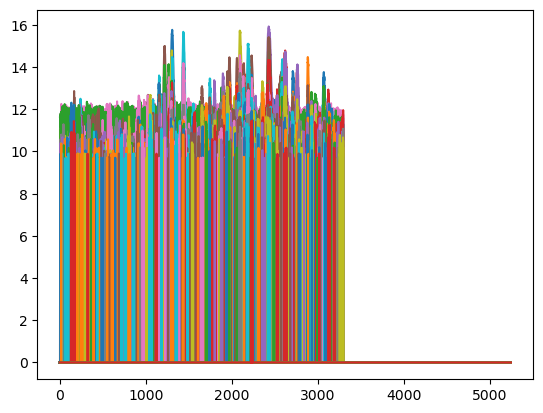

In [21]:
plt.plot(am);